In [4]:
!pip install wget | tail -n 1
!pip install scikit-learn | tail -n 1
!pip install "ibm-watson-machine-learning>=1.0.310" | tail -n 1


In [5]:
url = "https://us-south.ml.cloud.ibm.com"
apikey='UzPCW_Ve2lNof1xGulMWNKR7Fb0OehwFU9zYOifLY9j4'


In [6]:

credentials = {
    "url": url,
    "apikey": apikey
}


In [7]:

import os

try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = input("Please enter your project_id (hit enter): ")


project_id


'725a712c-00d6-4a69-846e-c78d0566987d'

In [8]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

# Define custom iterator function if needed
def _iter_(self):
    return 0

# Create COS client
cos_client = ibm_boto3.client(
    service_name='s3',
    ibm_api_key_id='UzPCW_Ve2lNof1xGulMWNKR7Fb0OehwFU9zYOifLY9j4',  # Replace with secure API key
    ibm_auth_endpoint='https://iam.cloud.ibm.com/oidc/token',
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.us-south.cloud-object-storage.appdomain.cloud'
)

# Define bucket and object key
bucket = 'handson-6-jnhgftrde'  # removed extra space
object_key = 'legal_sentiment_dataset (1).csv'

# Retrieve object
body = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Add iterator method if missing
if not hasattr(body, "_iter_"):
    body._iter_ = types.MethodType(_iter_, body)

# Read CSV using pandas
data = pd.read_csv(body)

# Display top 10 
print(data.head(10))

lable_map={
    -1:'negative',
     0:'netural',
     1: 'positive'
}
data.value_counts(['Sentiment'])


   ID                                            Phrase  Sentiment
0   1             The plaintiff's claims are dismissed.         -1
1   2     The contract is deemed valid and enforceable.          1
2   3        The appeal is denied due to lack of merit.         -1
3   4     The legal team submitted additional evidence.          0
4   5                The appeal is under consideration.          0
5   6  The settlement agreement is fair and reasonable.          1
6   7                The appeal is under consideration.          0
7   8  The settlement agreement is fair and reasonable.          1
8   9             The court reviewed the documentation.          0
9  10     The contract is deemed valid and enforceable.          1


Sentiment
 1           184
-1           167
 0           149
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd

data_train, data_test, y_train, y_test = train_test_split(
    data['Phrase'],
    data['Sentiment'],
    test_size=0.3,
    random_state=33,
    stratify=data['Sentiment']
)


# Convert to DataFrames
data_train = pd.DataFrame({'Phrase': data_train, 'Sentiment': y_train})
data_test = pd.DataFrame({'Phrase': data_test, 'Sentiment': y_test})


In [10]:
from ibm_watson_machine_learning.foundation_models.utils.enums import ModelTypes

print([model.name for model in ModelTypes])


['FLAN_T5_XXL', 'FLAN_UL2', 'MT0_XXL', 'GPT_NEOX', 'MPT_7B_INSTRUCT2', 'STARCODER', 'LLAMA_2_70B_CHAT', 'LLAMA_2_13B_CHAT', 'GRANITE_13B_INSTRUCT', 'GRANITE_13B_CHAT', 'FLAN_T5_XL', 'GRANITE_13B_CHAT_V2', 'GRANITE_13B_INSTRUCT_V2', 'ELYZA_JAPANESE_LLAMA_2_7B_INSTRUCT', 'MIXTRAL_8X7B_INSTRUCT_V01_Q', 'CODELLAMA_34B_INSTRUCT_HF', 'GRANITE_20B_MULTILINGUAL']


In [11]:
model_id = ModelTypes.FLAN_T5_XXL


In [12]:
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams

parameters = {
    GenParams.DECODING_METHOD: "greedy",
    GenParams.RANDOM_SEED: 33,
    GenParams.REPETITION_PENALTY: 1,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.MAX_NEW_TOKENS: 1
}


In [13]:

from ibm_watson_machine_learning.foundation_models import Model

model = Model(
    model_id=model_id,
    params=parameters,
    credentials=credentials,
    project_id=project_id
)



/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/ibm_watson_machine_learning/foundation_models/utils/utils.py:273: LifecycleWarning: Model 'google/flan-t5-xxl' is in deprecated state from 2025-05-28 until 2025-07-30. IDs of alternative models: None. Further details: https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-model-lifecycle.html?context=wx&audience=wdp
  warnings.warn(default_warning_template.format(


In [14]:
model.get_details()


{'model_id': 'google/flan-t5-xxl',
 'label': 'flan-t5-xxl-11b',
 'provider': 'Google',
 'source': 'Hugging Face',
 'functions': [{'id': 'text_generation'}],
 'short_description': 'flan-t5-xxl is an 11 billion parameter model based on the Flan-T5 family.',
 'long_description': 'flan-t5-xxl (11B) is an 11 billion parameter model based on the Flan-T5 family. It is a pretrained T5 - an encoder-decoder model pre-trained on a mixture of supervised / unsupervised tasks converted into a text-to-text format, and fine-tuned on the Fine-tuned Language Net (FLAN) with instructions for better zero-shot and few-shot performance.',
 'terms_url': 'https://huggingface.co/google/flan-t5-xxl/blob/main/README.md',
 'input_tier': 'class_2',
 'output_tier': 'class_2',
 'number_params': '11b',
 'min_shot_size': 0,
 'task_ids': ['question_answering',
  'summarization',
  'retrieval_augmented_generation',
  'classification',
  'generation',
  'extraction'],
 'tasks': [{'id': 'question_answering', 'ratings': {'

In [15]:
instruction = """Determine the sentiment of the sentence.
Use either 'positive', 'negative', 'neutral'. Use the provided examples as a template."""



In [16]:
zero_shot_inputs = [{"input": text} for text in data_test['Phrase']]
for i in range(2):
    print(f"The sentence example {i+1} is:\n\t {zero_shot_inputs[i]['input']}\n")



The sentence example 1 is:
	 The legal team submitted additional evidence.

The sentence example 2 is:
	 The appeal is denied due to lack of merit.



In [17]:

data_train_and_labels = data_train.copy()
data_train_and_labels['Sentiment'] = y_train


In [18]:
few_shot_example = []
few_shot_examples = []

for phrase, sentiment in data_train_and_labels \
    .groupby('Sentiment') \
    .apply(lambda x: x.sample(2)).values:
    
    few_shot_example.append(f"\tsentence:\t{phrase}\n\tsentiment: {sentiment}\n")
few_shot_examples = '\n'.join(few_shot_example)



In [19]:

few_shot_inputs_ = [{"input": text} for text in data_test['Phrase'].values]


In [20]:
for i in range(2):
    print(f"The sentence example {i+1} is:\n {few_shot_inputs_[i]['input']}\n")
    print(f"\tSentiment: {y_test.iloc[i]}\n")


The sentence example 1 is:
 The legal team submitted additional evidence.

	Sentiment: 0

The sentence example 2 is:
 The appeal is denied due to lack of merit.

	Sentiment: -1



In [21]:
results = []
for inp in few_shot_inputs_[:2]:
    results.append(
        model.generate(" ".join([instruction + few_shot_examples[0], inp['input']]))["results"][0]
    )


In [22]:
import json
print(json.dumps(results, indent=2))




[
  {
    "generated_text": "neutral",
    "generated_token_count": 1,
    "input_token_count": 42,
    "stop_reason": "max_tokens"
  },
  {
    "generated_text": "negative",
    "generated_token_count": 1,
    "input_token_count": 45,
    "stop_reason": "max_tokens"
  }
]


In [23]:


y_true = [lable_map[label] for label in y_test.values[:2]]
y_true

['netural', 'negative']

In [24]:

y_pred = [result['generated_text'] for result in results]
y_pred

['neutral', 'negative']

In [25]:
!pip install wordcloud 
!pip install sklearn.metrics
!pip install seaborn

ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


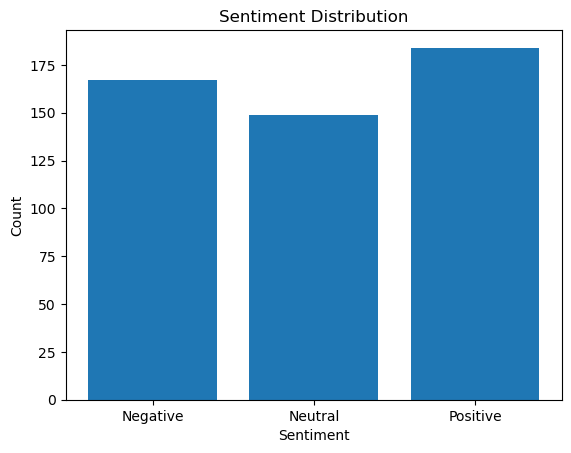

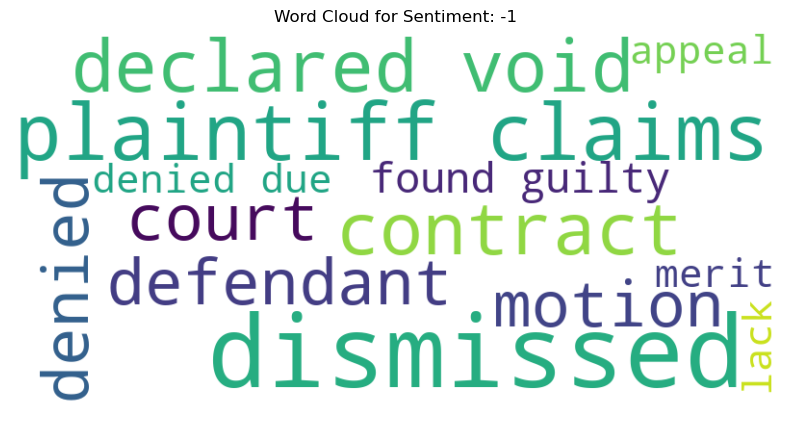

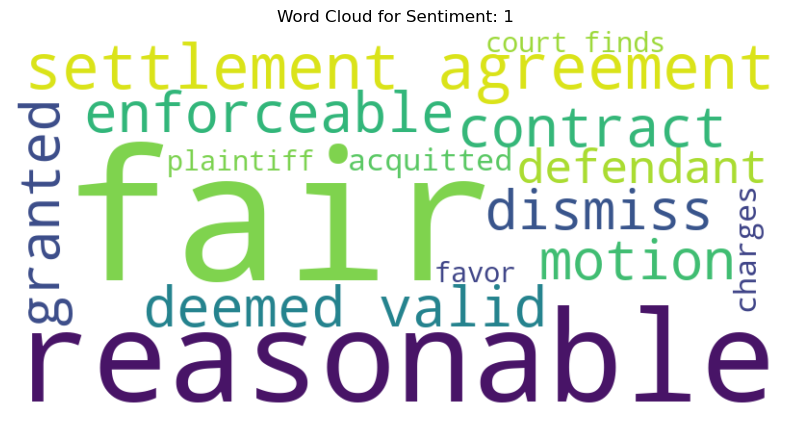

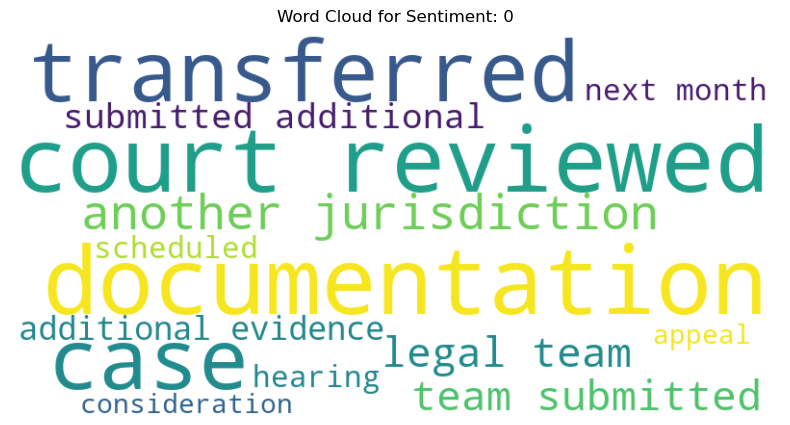

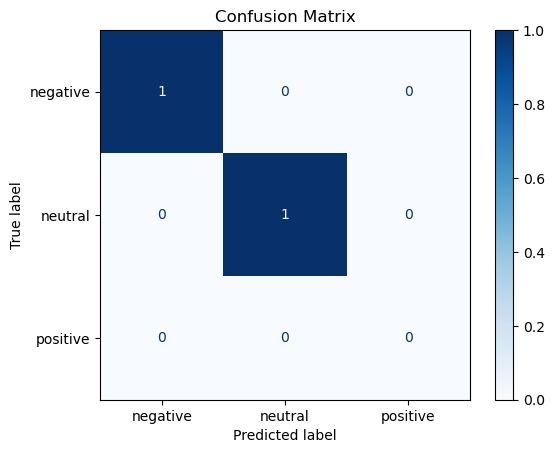

In [29]:
# --- Data Visualization ---

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# 1. Sentiment distribution
sentiment_counts = data['Sentiment'].value_counts().sort_index()
sentiment_labels = ['Negative', 'Neutral', 'Positive']

plt.bar(sentiment_labels, sentiment_counts)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# 2. Word Cloud for each sentiment
for sentiment in data['Sentiment'].unique():
    text = " ".join(data[data['Sentiment'] == sentiment]['Phrase'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Sentiment: {sentiment}')
    plt.show()

# 3. Confusion Matrix after your model predictions
# Replace `y_pred` with your model’s predictions
label_map = {-1: 'negative', 0: 'neutral', 1: 'positive'}

# Get the true and predicted values
y_true = [label_map[label] for label in y_test.values[:len(results)]]
y_pred = [result['generated_text'] for result in results]

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
